# NMF Model for Single Rank

In [5]:
from cvanmf import denovo
import pandas as pd
import plotnine as pn

In [2]:
# Parameters for decomposition generation
# All left None unless provided, so use cvanmf defaults
model = "../output/test/4/model"

In [3]:
# Load the model
top_model = denovo.Decomposition.load(model)

In [28]:
# Some utility constants for sizing plots etc.

# for plot_modelfit_point
# The number of samples that will be represent in one inch of horizontal space
PLOT_MODELFIT_PPI = 20
# Maximum width allowed for plot
PLOT_MODELFIT_MAX_WIDTH = 20

To edit or do further analysis on the model shown in this notebook, open it in Jupyter Lab or Notebook.

## Parameters


In [59]:
# Print the parameters, except the input matrix
{k:v for k,v in top_model.parameters._asdict().items() if k != 'x'}

{'rank': 4,
 'seed': 830760591,
 'alpha': 0.0,
 'l1_ratio': 1.0,
 'max_iter': 3000,
 'keep_mats': False,
 'beta_loss': 'kullback-leibler',
 'init': 'random'}

## Model Fit
We can measure how well the decomposition represents each sample, which we refer to as model fit.
This is calculated as the cosine similarity between the input values for a sample, and the reconstruced values (those in $WH$).
Cosine similarity for non-negative vectors falls between 0 (no relationship) and 1 (perfectly correlated).
A low median model fit indicates a poor model, however what is a poor median model fit will vary by field; however for genus level microbiome data  $<0.7$ seems an achievable median model fit.

Some samples having poor model fit is not neccesarily a disqualifying factor, depending on your use case.
Those samples may be in an unusual state for some reason (such as clinical factors), or represent interesting unusual deviations from a typical state.

### Distribution of Model Fit
Below is a histogram of the model fit across all samples, with a vertical line indicating median.

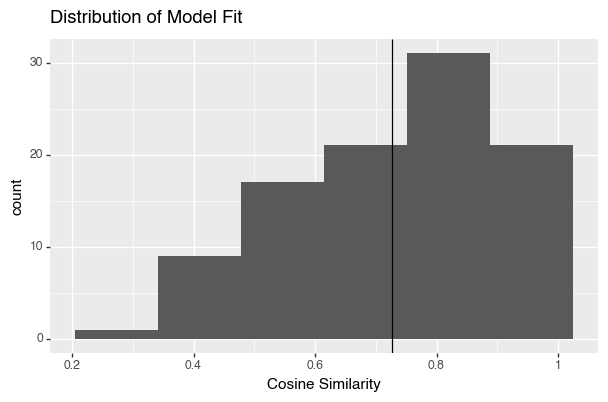

<Figure Size: (600 x 400)>

In [11]:
top_model.plot_modelfit() + pn.theme(figure_size=(6,4)) + pn.ggtitle("Distribution of Model Fit")

### Model Fit Per Sample
Below, the model fit is shown for each sample as a dot. Those below a threshold value are shown in red.
This threshold was determined for our Enterosignatures model, and may not be suitable for other data.
To use a different value, set the `threshold` parameter in `plot_modelfit_point()`.

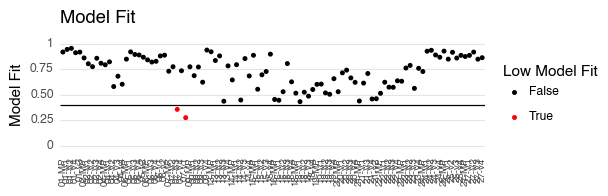

<Figure Size: (600 x 200)>

In [47]:
# Make the plot wider when there are more samples
modelfit_point_width = min((top_model.h.shape[1] / PLOT_MODELFIT_PPI) + 1, PLOT_MODELFIT_MAX_WIDTH)
# Customise width and text 
(
    top_model.plot_modelfit_point() + 
    pn.theme(
        figure_size=(modelfit_point_width, 2), 
        axis_text_x=pn.element_text(size=7)
    ) +
    pn.ggtitle("Model Fit")
)

# Feature Weights
Looking at the feature weights in each signature can help interpret the meaning of each signature.
Here we should the relative weight of features in each signature, meaning that the values in each signature are scaled to sum to 1.
The plot shows any features whose weight make up at least 4% of the total in the signature, this can be changed using the `threshold` parameter in `plot_feature_weight`.
Feature labels are trimmed by default to a maximum of 40 characters, but you can define some other method of truncating, or none using `label_fn`.

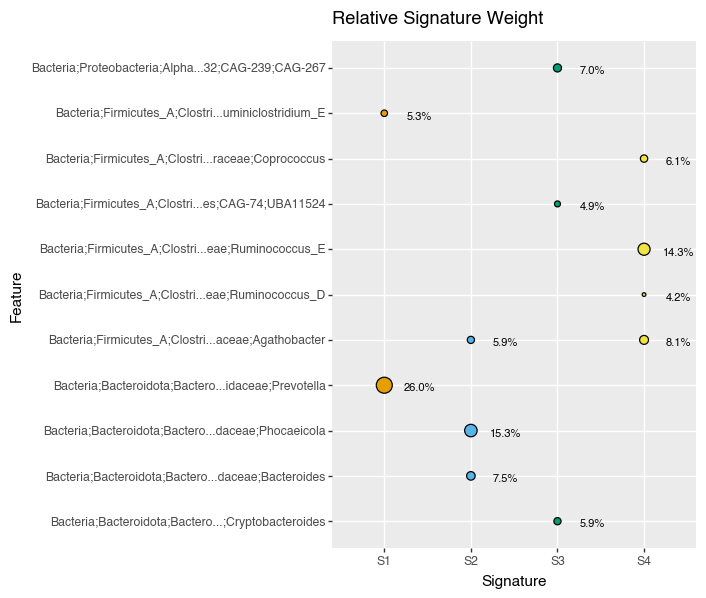

<Figure Size: (700 x 600)>

In [48]:
def truncate_name(x):
    if len(x) <= 40:
        return x
    return x[0:29] + "..." + x[-18:]
# Allow 1 inch per signature
feature_weight_width = top_model.w.shape[1] + 3
(
    top_model.plot_feature_weight(
        label_fn=truncate_name
    ) + 
    pn.theme(figure_size=(feature_weight_width, 6)) +
    pn.ggtitle("Relative Signature Weight")
)

# PCoA
Here PCoA is performed on the scaled signature weight matrix. For low rank models, this often doesn't show much, however it is more useful at higher ranks.
PCoA is carried out using Bray-Curtis dissimilarity, but can be customised - see documentation for `pcoa` and `plot_pcoa` methods of `Decomposition`.
This plot is often most useful when combined with metadata - you can use the `color` and `shape` arguments to provide categorical metadata to determine the shape and colour of points.

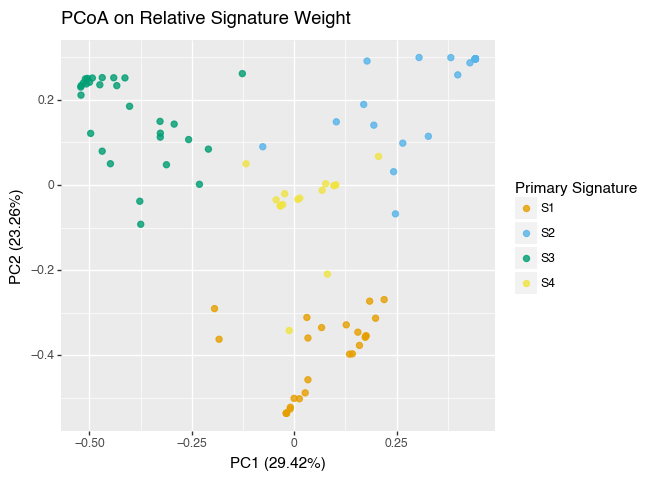

<Figure Size: (640 x 480)>

In [50]:
(
    top_model.plot_pcoa() +
    pn.ggtitle("PCoA on Relative Signature Weight")
)

### Relative Weight Plot
This represents the weight of each signature in each sample, with the weights in each sample scaled so that they sum to 1.
We also append the model fit point plot to the top.
This is the only figure which is not returned a `plotnine.ggplot` object, so we have to define widths etc in the call.
This plot can be quite expensive to produce when there are a lot of signatures or samples. 

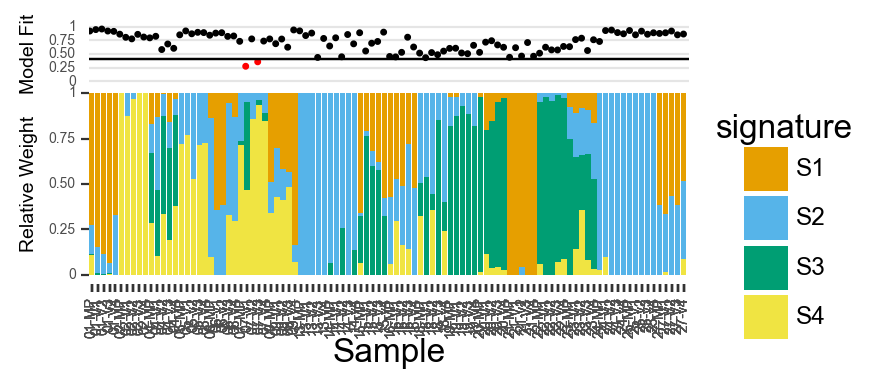

In [36]:
legend_cols = (top_model.w.shape[1] // 6) + 1
top_model.plot_relative_weight(
    heights=[0.3, 1], width=modelfit_point_width/2, point_size=.4,
    legend_cols_v=legend_cols
)

# Additional analyses available

## Against metadata
Methods are provided to plot signatures against metadata, as well as some simple statistical tests.
* `plot_metadata` takes a dataframe of metadata for each sample, and makes box plots for categorical and scatter plots for continuous medata. For categorical metadata, nonparametric statistical tests will be carried out.
* `univariate_tests` carries out either Mann-Whitney U tests or Kruskal-Wallis tests against relative signature weights for a dataframe of categorical metadata.

## Characterise samples
* `representative_signatures` indicates which signatures are representative of sample, found by taking all those which sum up to 90% of the total weight in the sample (though this threshold can be specified)